# No target-specific binding

In [ ]:
%load_ext slurm_magic

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=negative
#SBATCH --output=simulations/negative%a_%A.out
#SBATCH --gres=gpu:1   # Request 1 GPU
#SBATCH --array=0-4

lamdas=(0.01 0.05 0.15 0.5 1)

# Path to your executable
python ../examples/cosmos_simulations.py \
  --gain 7 --pi 0 --height 3000 --proximity 0.2 \
  -bs 4 --cuda --dtype double \
  --lamda ${lamdas[${SLURM_ARRAY_TASK_ID}]} \
  --path simulations/negative${lamdas[${SLURM_ARRAY_TASK_ID}]}

In [ ]:
%squeue

In [1]:
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path

from tapqir.models import Cosmos

## Load results

In [2]:
# path to simulated data
SIMULATIONS_DIR = Path("simulations")

In [3]:
truth = {}
fit = {}
predictions = defaultdict(dict)

for data_path in SIMULATIONS_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("negative"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        model = Cosmos(verbose=False)
        model.load(data_path, data_only=False)
        
        fit[data_path.name] = model.statistics.drop("trained").astype(float)
        for p in ("gain", "proximity", "pi", "lamda", "SNR"):
            fit[data_path.name].loc[p, "True"] = truth[data_path.name][p]
        
        mask = torch.from_numpy(model.data.ontarget.labels["z"])
        samples = torch.masked_select(model.params["p(specific)"], mask)
        predictions[data_path.name]["z_masked"] = samples
        predictions[data_path.name]["z_all"] = model.params["p(specific)"].flatten()

In [4]:
truth_df = pd.concat(truth.values(), axis=1).T.sort_values(by="lamda").astype(float)
truth_df

,width,gain,pi,lamda,proximity,offset,height,background,SNR,N,F,Nc,Fc,P
negative0.01,1.4,7.0,0.0,0.01,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0
negative0.05,1.4,7.0,0.0,0.05,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0
negative0.15,1.4,7.0,0.0,0.15,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0
negative0.5,1.4,7.0,0.0,0.50,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0
negative1,1.4,7.0,0.0,1.00,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0


In [5]:
description = pd.Series(dtype=str, name="Description")
description["N"] = "Number of on-target AOIs"
description["F"] = "Number of frames for on-target AOIs"
description["Nc"] = "Number of control off-target AOIs"
description["Fc"] = "Number of frames for off-target AOIs"
description["P"] = "Number of pixels along x- and y-axes of an AOI"
description["height"] = "Spot intensity"
description["width"] = "Spot width"
description["snr"] = "Signal-to-noise ratio"
description["background"] = "Image background"
description["pi"] = "Average target-specific binding probability"
description["lamda"] = "Non-specific binding rate"
description["proximity"] = "Proximity parameter"
description["p(specific)"] = "Probability of there being any target-specific spot in an AOI image"
description["_ul"] = "95% CI upper-limit"
description["_ll"] = "95% CI lower-limit"
description["MCC"] = "Matthews correlation coefficient"
description["TP"] = "True positives"
description["FN"] = "False negatives"
description["TN"] = "True negatives"
description["FP"] = "False positives"

## Supplementary Data 4

In [6]:
with pd.ExcelWriter("/home/ordabayev/repos/tapqir-overleaf/supplementary/data4/negative.xlsx") as writer:
    truth_df.to_excel(writer, sheet_name="simulation")
    for key, value in fit.items():
        value.to_excel(writer, sheet_name=key)
    description.to_excel(writer, sheet_name="description")

## Figure 5

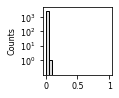

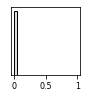

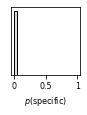

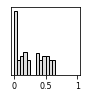

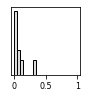

In [7]:
for name in truth_df.index:
    plt.figure(figsize=(1.25, 1.25))
    plt.hist(predictions[name]["z_all"].numpy(),
             bins=torch.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="#dddddd", edgecolor="k",
             label=f"{truth_df.loc[name, 'SNR']:.2f} SNR")
    plt.hist(predictions[name]["z_masked"].numpy(),
             bins=torch.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="C2", edgecolor="k", alpha=0.6,
             label=f"{truth_df.loc[name, 'SNR']:.2f} SNR")
    plt.yscale("log")
    plt.xlim(-0.05,1.05)
    plt.ylim(1e-1, 5e3)
    plt.xticks([0, 0.5, 1], fontsize=8)
    
    if name == "negative0.01":
        plt.ylabel("Counts", fontsize=8)
        plt.yticks([1, 10, 100, 1000], fontsize=8)
    else:
        plt.yticks([])
    if name == "negative0.15":
        plt.xlabel(r"$p(\mathsf{specific})$", fontsize=8)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure5/{name}.svg")
    plt.show()